## 1. Setup and Imports

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pathlib import Path

import config
from model import create_model, count_parameters
from data import create_dataloaders
from evaluate import evaluate_model, generate_classification_report
from utils import load_model, plot_confusion_matrix

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {config.DEVICE}")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
Device: cuda


## 2. Load Test Dataset

In [52]:
_, _, test_loader = create_dataloaders(
    batch_size=config.BATCH_SIZE,
    num_workers=2
)

print(f"Test dataset loaded: {len(test_loader.dataset)} samples")
print(f"Classes: {', '.join(config.CLASS_NAMES)}")

Test dataset loaded: 405 samples
Classes: Early_Blight, Healthy, Late_Blight


## 3. Load and Evaluate Custom CNN Model

In [53]:
cnn_checkpoint = config.CHECKPOINT_DIR / "cnn_model_best.pth"

if cnn_checkpoint.exists():
    print(f"Loading CNN model from: {cnn_checkpoint}")
    cnn_model = create_model('cnn', config.DEVICE)
    
    checkpoint = torch.load(cnn_checkpoint, map_location=config.DEVICE)
    cnn_model.load_state_dict(checkpoint['model_state_dict'])
    cnn_epoch = checkpoint['epoch']
    cnn_best_val_acc = checkpoint.get('best_val_acc', 'N/A')
    cnn_best_val_loss = checkpoint.get('best_val_loss', 'N/A')
    cnn_train_time = checkpoint.get('training_time', 'N/A')
    
    print(f"\n{'='*50}")
    print(f"Convergence Epoch: {cnn_epoch}")
    print(f"Best Validation Accuracy: {cnn_best_val_acc if isinstance(cnn_best_val_acc, str) else f'{cnn_best_val_acc:.2f}%'}")
    print(f"Best Validation Loss: {cnn_best_val_loss if isinstance(cnn_best_val_loss, str) else f'{cnn_best_val_loss:.4f}'}")
    print(f"Training Duration: {cnn_train_time if isinstance(cnn_train_time, str) else f'{cnn_train_time:.2f}s'}")
    print(f"{'='*50}")
    
    cnn_total, cnn_trainable = count_parameters(cnn_model)
    print(f"Total parameters: {cnn_total:,}")
    print(f"Trainable parameters: {cnn_trainable:,}")
else:
    print(f"ERROR: Checkpoint not found at {cnn_checkpoint}")

Loading CNN model from: c:\Users\Mikhael\Documents\Deep-Learning-AOL\checkpoints\cnn_model_best.pth
Created Custom CNN model

Custom CNN Model Summary:
Total parameters: 6,944,515
Trainable parameters: 6,944,515
Non-trainable parameters: 0

Architecture:
- Conv Block 1: 3 -> 32 channels
- Conv Block 2: 32 -> 64 channels
- Conv Block 3: 64 -> 128 channels
- Conv Block 4: 128 -> 256 channels
- FC Layer 1: 12544 -> 512
- FC Layer 2: 512 -> 256
- Output Layer: 256 -> 3
- Dropout Rate: 0.5


Custom CNN Model Summary:
Total parameters: 6,944,515
Trainable parameters: 6,944,515
Non-trainable parameters: 0

Architecture:
- Conv Block 1: 3 -> 32 channels
- Conv Block 2: 32 -> 64 channels
- Conv Block 3: 64 -> 128 channels
- Conv Block 4: 128 -> 256 channels
- FC Layer 1: 12544 -> 512
- FC Layer 2: 512 -> 256
- Output Layer: 256 -> 3
- Dropout Rate: 0.5


Convergence Epoch: 38
Best Validation Accuracy: 98.80%
Best Validation Loss: 0.0365
Training Duration: N/A
Total parameters: 6,944,515
Trainab

C:\Users\Mikhael\AppData\Local\Temp\ipykernel_2540\2357179716.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cnn_checkpoint, map_location=config

In [54]:
import time
from sklearn.metrics import precision_recall_fscore_support

if cnn_model is not None:
    print("Evaluating Custom CNN...\n")
    
    start_time = time.time()
    cnn_accuracy, cnn_loss, cnn_true, cnn_pred = evaluate_model(
        cnn_model, 
        test_loader, 
        config.DEVICE
    )
    cnn_inference_time = time.time() - start_time
    
    cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
        cnn_true, cnn_pred, average='weighted'
    )
    
    cnn_model_size = sum(p.numel() * p.element_size() for p in cnn_model.parameters()) / (1024 * 1024)
    
    print(f"Evaluation completed in {cnn_inference_time:.2f}s")

Evaluating Custom CNN...



Evaluation completed in 7.71s


In [55]:
if cnn_model is not None:
    print("Custom CNN - Classification Report:")
    print("="*60)
    print(generate_classification_report(cnn_true, cnn_pred, config.CLASS_NAMES))

Custom CNN - Classification Report:
              precision    recall  f1-score   support

Early_Blight     1.0000    0.9877    0.9938       162
     Healthy     0.9808    1.0000    0.9903       102
 Late_Blight     0.9929    0.9929    0.9929       141

    accuracy                         0.9926       405
   macro avg     0.9912    0.9935    0.9923       405
weighted avg     0.9927    0.9926    0.9926       405



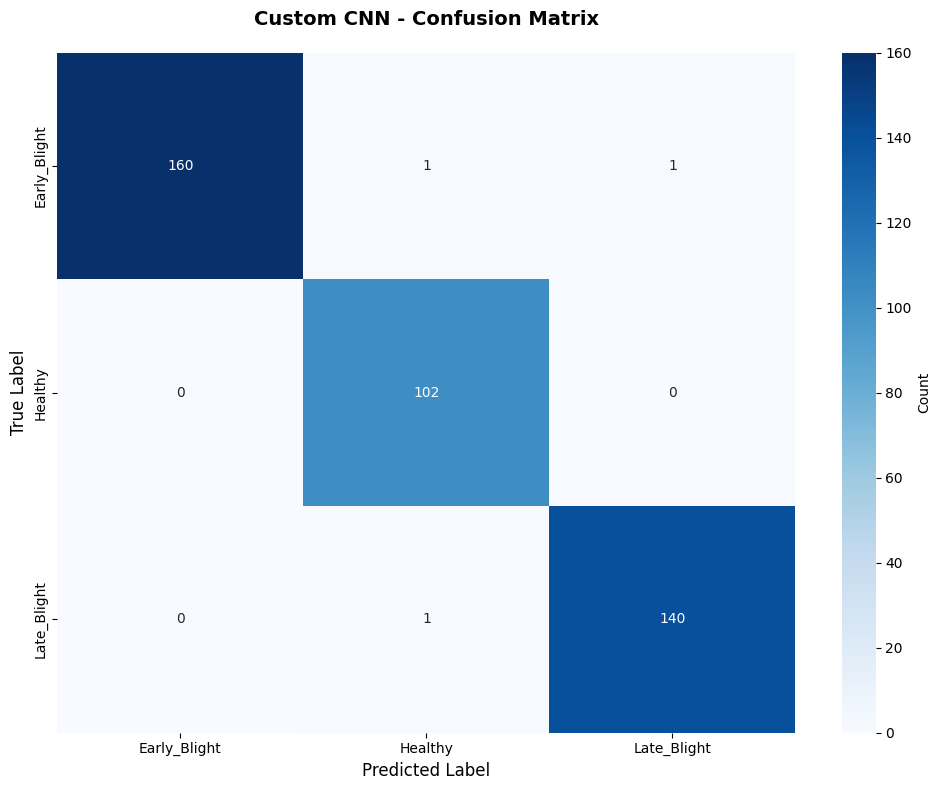

In [56]:
if cnn_model is not None:
    cnn_cm = confusion_matrix(cnn_true, cnn_pred)
    plot_confusion_matrix(cnn_cm, config.CLASS_NAMES, model_name='Custom CNN')

## 4. Load and Evaluate ResNet50 Model

In [57]:
resnet_checkpoint = config.CHECKPOINT_DIR / "resnet_model_best.pth"

if resnet_checkpoint.exists():
    print(f"Loading ResNet50 model from: {resnet_checkpoint}")
    resnet_model = create_model('resnet', config.DEVICE)
    
    checkpoint = torch.load(resnet_checkpoint, map_location=config.DEVICE)
    resnet_model.load_state_dict(checkpoint['model_state_dict'])
    resnet_epoch = checkpoint['epoch']
    resnet_best_val_acc = checkpoint.get('best_val_acc', 'N/A')
    resnet_best_val_loss = checkpoint.get('best_val_loss', 'N/A')
    resnet_train_time = checkpoint.get('training_time', 'N/A')
    
    print(f"\n{'='*50}")
    print(f"Convergence Epoch: {resnet_epoch}")
    print(f"Best Validation Accuracy: {resnet_best_val_acc if isinstance(resnet_best_val_acc, str) else f'{resnet_best_val_acc:.2f}%'}")
    print(f"Best Validation Loss: {resnet_best_val_loss if isinstance(resnet_best_val_loss, str) else f'{resnet_best_val_loss:.4f}'}")
    print(f"Training Duration: {resnet_train_time if isinstance(resnet_train_time, str) else f'{resnet_train_time:.2f}s'}")
    print(f"{'='*50}")
    
    resnet_total, resnet_trainable = count_parameters(resnet_model)
    print(f"Total parameters: {resnet_total:,}")
    print(f"Trainable parameters: {resnet_trainable:,}")
else:

    print(f"ERROR: Checkpoint not found at {resnet_checkpoint}")

Loading ResNet50 model from: c:\Users\Mikhael\Documents\Deep-Learning-AOL\checkpoints\resnet_model_best.pth
Created ResNet50 transfer learning model

ResNet50 Transfer Learning Model Summary:
Total parameters: 24,558,659
Trainable parameters: 24,333,315
Non-trainable parameters: 225,344

Configuration:
- Pretrained: True
- Fine-tune layers: 3
- Output classes: 3

Fine-tuning Strategy:
- Training classifier + last 3 layer(s)
Created ResNet50 transfer learning model

ResNet50 Transfer Learning Model Summary:
Total parameters: 24,558,659
Trainable parameters: 24,333,315
Non-trainable parameters: 225,344

Configuration:
- Pretrained: True
- Fine-tune layers: 3
- Output classes: 3

Fine-tuning Strategy:
- Training classifier + last 3 layer(s)


C:\Users\Mikhael\AppData\Local\Temp\ipykernel_2540\4187853786.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resnet_checkpoint, map_location=con


Convergence Epoch: 11
Best Validation Accuracy: 99.52%
Best Validation Loss: 0.0109
Training Duration: N/A
Total parameters: 24,558,659
Trainable parameters: 24,333,315


In [63]:
init resnet_model is not None:
    print("Evaluating ResNet50...\n")
    
    start_time = time.time()
    resnet_accuracy, resnet_loss, resnet_true, resnet_pred = evaluate_model(
        resnet_model, 
        test_loader, 
        config.DEVICE
    )
    resnet_inference_time = time.time() - start_time
    
    resnet_precision, resnet_recall, resnet_f1, _ = precision_recall_fscore_support(
        resnet_true, resnet_pred, average='weighted'
    )
    
    resnet_model_size = sum(p.numel() * p.element_size() for p in resnet_model.parameters()) / (1024 * 1024)
    
    print(f"Evaluation completed in {resnet_inference_time:.2f}s")

SyntaxError: invalid syntax (3709730238.py, line 1)

In [59]:
if resnet_model is not None:
    print("ResNet50 - Classification Report:")
    print("="*60)
    print(generate_classification_report(resnet_true, resnet_pred, config.CLASS_NAMES))

ResNet50 - Classification Report:
              precision    recall  f1-score   support

Early_Blight     1.0000    0.9815    0.9907       162
     Healthy     0.9712    0.9902    0.9806       102
 Late_Blight     0.9859    0.9929    0.9894       141

    accuracy                         0.9877       405
   macro avg     0.9857    0.9882    0.9869       405
weighted avg     0.9878    0.9877    0.9877       405



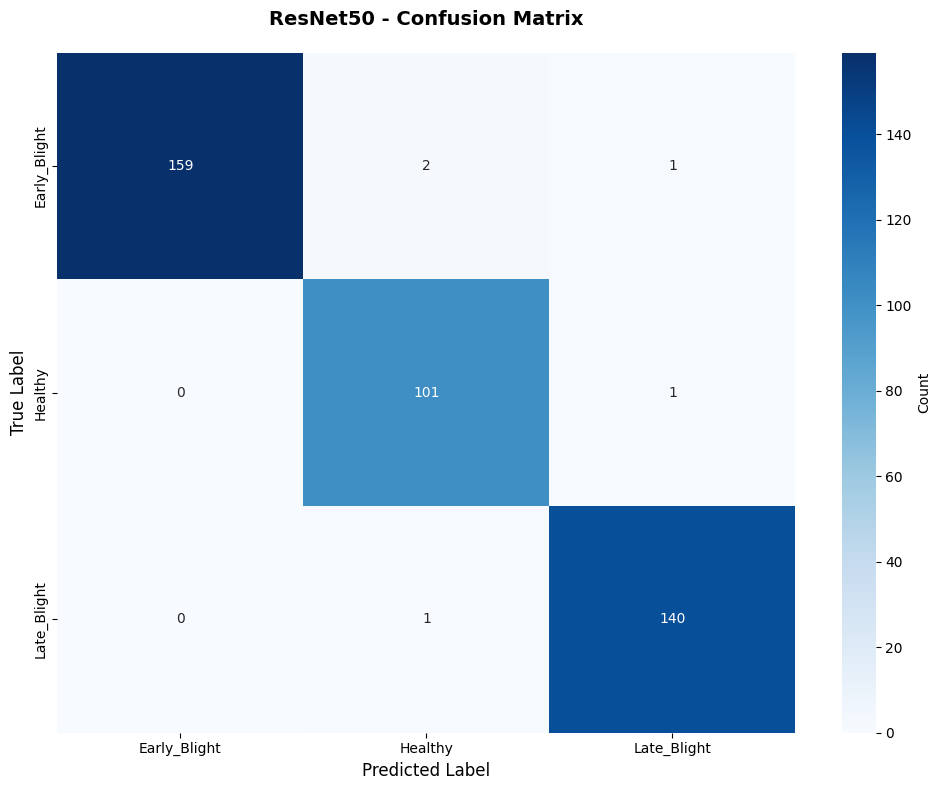

In [60]:
if resnet_model is not None:
    resnet_cm = confusion_matrix(resnet_true, resnet_pred)
    plot_confusion_matrix(resnet_cm, config.CLASS_NAMES, model_name='ResNet50')

## 5. Model Comparison Summary

In [61]:
if cnn_model is not None and resnet_model is not None:
    num_samples = len(test_loader.dataset)
    cnn_avg_time_ms = (cnn_inference_time / num_samples) * 1000
    resnet_avg_time_ms = (resnet_inference_time / num_samples) * 1000
    
    print("\n" + "="*90)
    print("MODEL PERFORMANCE METRICS")
    print("="*90)
    
    print(f"{'Metric':<25} {'Custom CNN':<25} {'ResNet50':<25}")
    print("-" * 90)
    print(f"{'Accuracy (%)':<25} {cnn_accuracy:<25.2f} {resnet_accuracy:<25.2f}")
    print(f"{'Precision (Avg %)':<25} {cnn_precision*100:<25.2f} {resnet_precision*100:<25.2f}")
    print(f"{'Recall (Avg %)':<25} {cnn_recall*100:<25.2f} {resnet_recall*100:<25.2f}")
    print(f"{'F1-Score (Avg %)':<25} {cnn_f1*100:<25.2f} {resnet_f1*100:<25.2f}")
    print(f"{'Inference Time (s)':<25} {cnn_inference_time:<25.2f} {resnet_inference_time:<25.2f}")
    print(f"{'Avg Time/Image (ms)':<25} {cnn_avg_time_ms:<25.2f} {resnet_avg_time_ms:<25.2f}")
    print(f"{'Model Size (MB)':<25} {cnn_model_size:<25.2f} {resnet_model_size:<25.2f}")
    print("="*90)


MODEL PERFORMANCE METRICS
Metric                    Custom CNN                ResNet50                 
------------------------------------------------------------------------------------------
Accuracy (%)              99.26                     98.77                    
Precision (Avg %)         99.27                     98.78                    
Recall (Avg %)            99.26                     98.77                    
F1-Score (Avg %)          99.26                     98.77                    
Inference Time (s)        7.71                      9.79                     
Avg Time/Image (ms)       19.05                     24.17                    
Model Size (MB)           26.49                     93.68                    
